<a href="https://colab.research.google.com/github/hitoshitoshi/Social-Media-Bot-Classification/blob/main/Project_Proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing Tree- and Neural-Based Approaches for Social Media Bot Classification

by Arnav (apallem), Joao (jscastro), Simon (sbeyzero)

In [74]:
import pickle
import json
import numpy as np

train = False

# Model Card

**Task Input and Output.**
Our task is binary classification based on an input feature vector describing a user on VK.com, including numeric and categorical features derived from their social media profile. The output is a probability value between 0 and 1 representing the likelihood that the user is a bot.

**Training Data.**
Our training data comes from the Kaggle dataset "Users vs Bots Classification" by Aleksei Zagorskii (https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification/data), based on public profile data from VK.com---Russia's largest social media page. The dataset contains roughly 6,000 samples with 59 features, including a mix of numerical, categorical, and binary data. We preprocess the dataset by encoding categorical values and normalizing numerical ones when appropriate.

**Intended Use.**
The trained model is designed to study the challenges of bot detection using machine learning. Similar, more robust models could be used to moderate social media platforms by flagging suspicious or automated accounts. However, this particular model is trained only on VK.com data, which limits its generalization to other (international) platforms like Instagram without additional tuning and data.

**Risks.**
There are clear risks for bias and misclassification. In particular, when features reflect user behavior that may vary culturally or demographically. False positives that misclassify legitimate users as bots can lead to reduced platform trust and unjust restrictions on free speech. Also, bots becoming increasingly sophisted could reduce model effectiveness over time, making models like this one potentially useful for adversarial training by developers of these bots.

# Introduction

The dead internet theory, proposed in 2021, states that the internet is mostly consisted of computers that automatically generate content supposed to control people and minimize human produced content. Whether that is true or just a silly fantasy, it demonstrates the danger that a social media that is overly populated by bots could cause. On top of that, it could lead to more scams and spam.

We decided to create a model that would differentiate a user and a bot based on its information. To do this, we experimented with two techniques. The first method we will experiment is using XGBoost, a machine learning library that implements gradient-boosting decision trees. This library is commonly used for these kinds of classification problems and works by creating small decision trees whose error influences how the next decision tree is fit. Our second technique is a basic neural network with 6 linear layers that outputs a probability that a user is a bot or not.

Through these two methods we will explore the experimental question: **How does replacing missing values with zeroes or the most common value for that feature affect model performance in neural networks compared to decision tree models?**

In [75]:
#@title Setup Kaggle Dataset

# Kaggle
%pip install kagglehub
import kagglehub
import os
import pandas as pd
kagglehub.login()

# Download latest version
path = kagglehub.dataset_download("juice0lover/users-vs-bots-classification")
print("Path to dataset files:", path)

files = os.listdir(path)

#just loads the first file in the directory. Only 1 csv file in this case:
df = pd.read_csv(os.path.join(path, files[0]))

df.head()

Path to dataset files: /kaggle/input/users-vs-bots-classification


,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown


# Methods

As our experiment, we will be testing how the models reacts when we replace missing data with zeroes, compared to when we replace them with the most common value in the feature in both neural networks and XGBoost. For this, we have created the experimental question: **How does replacing missing values with zeroes or the most common value for that feature affect model performance in neural networks compared to decision tree models?**

In [76]:
## Data Transformations to deal with missing values

from sklearn.model_selection import train_test_split

def handle_missing(data):
  missing = data.copy()
  missing = missing.drop('city', axis=1) #Dropping city because there are too many categories for a neural net
  missing = missing.replace("Unknown", np.nan)
  missing['subscribers_count'] = missing['subscribers_count'].astype('float64')
  missing = pd.get_dummies(missing, drop_first=False, dtype = 'float64')
  for col in missing.select_dtypes(include = ['object', 'float64']):
    mode_val = missing[col].mode()
    if not mode_val.empty:
        missing[col] = missing[col].fillna(mode_val[0])
    if missing[col].dtype == "object":
      missing[col] = missing[col].astype('float64')

  return missing

transformed_df = handle_missing(df)
X_trans = transformed_df.drop(columns=['target'])
y_trans = transformed_df['target']

X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(X_trans, y_trans, train_size = 0.8)


## Method 1: XGBoost

The first method that we implemented was a binary classification model using XGBoost. It is an optimized gradient-boosted-tree library. We chose to use an 80/20 train-test split. By setting categorical features to a category datatype, we ensure that XGBoost will perform its own efficient encoding. We also create a custom accuracy function to vizualize how well the model is training. We run a total of 30 rounds(epochs), which we found to be enough to achieve convergence. We used a "binary:logistic" objective function which minimizes binary cross-entropy loss while also having a tree-complexity penalty to avoid overfitting.

In [77]:
#@title Load XGBoost

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score


In [78]:
#@title Data Setup for XGBoost

X = df.drop(columns=['target'])
y = df['target']
for col in X.select_dtypes(include = ['object']):
  X[col] = X[col].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

print(f"Shape of data: {(X_train.shape)}")

#Setting up data for XGBoost
d_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
d_test = xgb.DMatrix(X_test, y_test, enable_categorical= True)
param = {"objective": "binary:logistic"}
watch_list = [(d_test, "eval"), (d_train, "train")]
results = {}
def acc(preds, data):
  labels = data.get_label()
  return 'accuracy', float(sum(labels == (preds > 0.5))) / len(labels)
num_rounds = 30

#Setting up data for XGBoost
d_train_trans = xgb.DMatrix(X_train_trans, y_train_trans, enable_categorical=True)
d_test_trans = xgb.DMatrix(X_test_trans, y_test_trans, enable_categorical= True)
watch_list_trans = [(d_test_trans, "eval"), (d_train_trans, "train")]
results_trans = {}

Shape of data: (4699, 59)


In [79]:
#@title Train XGBoost Models
if train:
  mod = xgb.train(params=param, dtrain=d_train, num_boost_round = num_rounds, evals = watch_list, evals_result = results, custom_metric = acc)

  mod = xgb.train(params=param, dtrain=d_train_trans, num_boost_round = num_rounds, evals = watch_list_trans, evals_result = results_trans, custom_metric = acc)
  with open("xgb_results.json", "w") as f:
    json.dump(results, f)

  with open("xgb_results_trans.json", "w") as f:
    json.dump(results_trans, f)
else:
  with open("xgb_results.json", "r") as f:
    results = json.load(f)

  with open("xgb_results_trans.json", "r") as f:
    results_trans = json.load(f)


## Method 2: Neural Network

The second method that we implemented was a simple neural network that consists of 5 linear layers(input -> 16 -> 32 -> 64 -> 32 -> 2), each followed by a ReLU activation layer except for the last one which is proceeded by a softmax layer. On the two output values we use a cross-entropy loss function. We train our model for 50 epochs, which we found to be a good value for convergence, using the the adam optimizer.

Before training the data, we make sure to remove any categorical values. We also break the data into an 80/20 train-test split.

In [80]:
#@title Setup PyTorch

import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np


In [81]:
#@title Data Setup for PyTorch

class myDataset(torch.utils.data.Dataset):

  def __init__(self, X, y, transforms = False):

    self.data = X
    self.labels = y
    if not transforms:
      self.data = self.data.select_dtypes(exclude = ['category'])
    self.data = self.data.to_numpy()
    self.data = np.nan_to_num(self.data)
    self.labels = self.labels.to_numpy()

  def __len__(self):
    return self.labels.shape[0]

  def collate_fn(self, batch):
      x, y = zip(*batch)

      return torch.tensor(np.array(x)), torch.tensor(y)

  def __getitem__(self, idx):
    return (self.data[idx], self.labels[idx])


torch_data_train = myDataset(X_train, y_train)
torch_data_test = myDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(
    dataset     = torch_data_train,
    num_workers = 0,
    batch_size  = 512,
    pin_memory  = True,
    shuffle     = True,
    collate_fn = torch_data_train.collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset     = torch_data_test,
    num_workers = 0,
    batch_size  = 128,
    pin_memory  = True,
    shuffle     = False
)

dataset_trans = myDataset(X_train_trans, y_train_trans, True)
val_trans = myDataset(X_test_trans, y_test_trans, True)
train_loader_trans = torch.utils.data.DataLoader(
    dataset     = dataset_trans,
    num_workers = 0,
    batch_size  = 512,
    pin_memory  = True,
    shuffle     = True,
    collate_fn = dataset_trans.collate_fn
)

test_loader_trans = torch.utils.data.DataLoader(
    dataset     = val_trans,
    num_workers = 0,
    batch_size  = 128,
    pin_memory  = True,
    shuffle     = False
)



In [82]:
#@title PyTorch Model Setup

criterion = torch.nn.CrossEntropyLoss()

class myModel(nn.Module):

  def __init__(self, input_feats):
    super(myModel, self).__init__()
    self.layers = torch.nn.Sequential(nn.Linear(input_feats, 16, dtype=torch.float64),
                                torch.nn.ReLU(),
                                nn.Linear(16, 32, dtype=torch.float64),
                                torch.nn.ReLU(),
                                nn.Linear(32, 64, dtype=torch.float64),
                                torch.nn.ReLU(),
                                nn.Linear(64, 32, dtype=torch.float64),
                                torch.nn.ReLU(),
                                nn.Linear(32, 2, dtype=torch.float64))
    self.initialize_weights()

  def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)

                m.bias.data.fill_(0)


  def forward(self, x):
    x = torch.flatten(x, start_dim = 1)
    return self.layers(x)


################################################################################

def train_one_epoch(dataloader, optimizer):
    running_loss = 0.
    running_acc = 0.


    for i, (inputs, labels) in enumerate(dataloader):
        # Every data instance is an input + label pair


        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        preds = (probs[:, 0] < 0.5).int()
        diffs = preds ^ labels

        miss = torch.sum(diffs)
        correct = len(diffs) - miss

        running_acc += correct

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()


    return (running_loss / len(dataloader), running_acc / len(dataloader.dataset))

def val_mod(dataloader, optimizer):
    running_acc = 0.



    for i, (inputs, labels) in enumerate(dataloader):

        outputs = model(inputs)
        softmax = nn.Softmax(dim=1)
        outputs = softmax(outputs)
        preds = (outputs[:, 0] < 0.5).int()
        diffs = preds ^ labels
        loss = torch.sum(diffs)
        correct = len(diffs) - loss
        running_acc += correct

        # Gather data and report

    return running_acc / len(dataloader.dataset)

################################################################################





In [83]:
#@title Train PyTorch Model
model = myModel(14)
# Choose an appropriate optimizer of your choice
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

if train:
  train_acc = []
  val_acc = []
  for epoch in range(50):
    loss, acc = train_one_epoch(train_loader, optimizer)
    train_acc.append(acc)
    val_a = val_mod(test_loader, optimizer)
    val_acc.append(val_a)

  with open("results.pkl", "wb") as f:
    pickle.dump({
      "train_acc": train_acc,
      "val_acc": val_acc
    }, f)
else:
  with open("results.pkl", "rb") as f:
    data = pickle.load(f)
    train_acc = data["train_acc"]
    val_acc = data["val_acc"]

model = myModel(101)
# Choose an appropriate optimizer of your choice
optimizer_trans = torch.optim.AdamW(model.parameters(), lr=0.0001)

if train:
  train_acc_trans = []
  val_acc_trans = []
  for epoch in range(50):
    loss2, acc2 = train_one_epoch(train_loader_trans, optimizer_trans)
    train_acc_trans.append(acc2)
    val_a = val_mod(test_loader_trans, optimizer_trans)
    val_acc_trans.append(val_a)

  with open("results_trans.pkl", "wb") as f:
    pickle.dump({
      "train_acc_trans": train_acc_trans,
      "val_acc_trans": val_acc_trans
    }, f)
else:
  with open("results_trans.pkl", "rb") as f:
    data = pickle.load(f)
    train_acc_trans = data["train_acc_trans"]
    val_acc_trans = data["val_acc_trans"]


# Results & Discussion

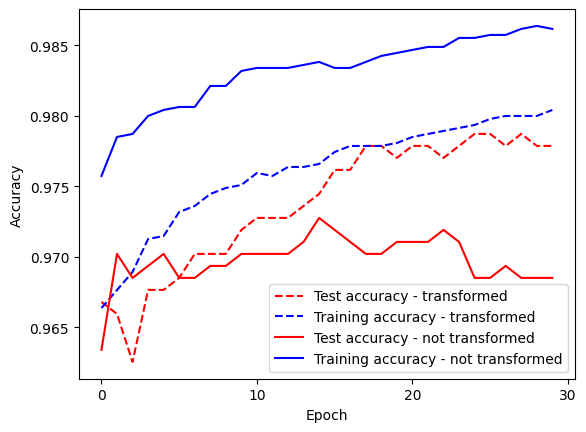

In [84]:
plt.plot(results_trans['eval']['accuracy'], label = "Test accuracy - transformed", color = 'r', linestyle = '--')
plt.plot(results_trans['train']['accuracy'], label = "Training accuracy - transformed" ,color = 'b', linestyle = '--')
plt.plot(results['eval']['accuracy'], label = "Test accuracy - not transformed", color = 'r')
plt.plot(results['train']['accuracy'], label = "Training accuracy - not transformed" ,color = 'b')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([i*10 for i in range(4)])
plt.show()

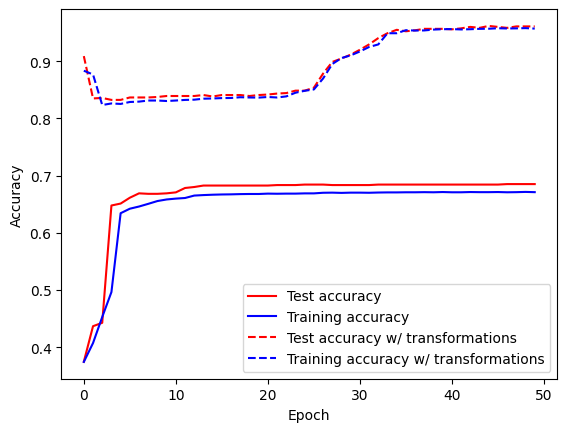

In [85]:
# @title
plt.plot(val_acc, label = "Test accuracy", color = 'r')
plt.plot(train_acc, label = "Training accuracy" ,color = 'b')
plt.plot(val_acc_trans, label = "Test accuracy w/ transformations", color = 'r', linestyle = '--')
plt.plot(train_acc_trans, label = "Training accuracy w/ transformations" ,color = 'b', linestyle = '--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks([i*10 for i in range(6)])
plt.show()


For our XGBoost results, you can see that the effects of having zeros or transormed data didn't have a great effect on our testing accuracy. On the other hand, for our training accuracy, although not as important as testing, had a small improvement when training with zeroes. This could point to the data having a little overfitting when transformed.

For our neural network, however, the effects of transformed data are really apparent. When using zeroes, our model had an accuracy lower than 0.7, which compared to random guesses(0.5), isn't ideal at all. However when we used our transformed data, we improved our testing accuracy to around 0.93, a considerable improvement.

Comparing between XGBoost and Neural Networks, XGBoost was superior. Comparing both with transformations, XGBoost has around a 0.04 higher testing accuracy than our neural network. I believe that a considerable amount of this came from the fact that XGBoost is able to categorize values, whereas in neural networks we remove them.

The greatest limitation in our two methods was exactly that for neural networks. We lose a great portion of data from the fact that we remove features that are categorical, which could be important to determining an output.

I believe that with greater research and improved knowledge, there could potentially be an even better method, however, looking at our results for XGBoost, it would be difficult to improve a testing accuracy to something even higher than 0.98



# References

Aleksei Zagorskii. (April 2025). Starter notebook: Bots-vs-User Classification, V3. https://www.kaggle.com/code/juice0lover/starter-notebook-bots-vs-user-classification/notebook